# Data formatting for STGAN
# `dataset2`
## Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from numba import jit

## Cameras

In [2]:
cams = pd.read_csv("traffic_data/dataset1/CamerasGPSinfo.csv")
cams

,CamId,Longitude,Latitude,Bearing
0,1,11.986280,57.697137,155
1,2,11.985522,57.696668,85
2,4,11.965964,57.706792,90
3,5,11.977686,57.708775,175
4,6,11.972374,57.707239,60
...,...,...,...,...
129,115,11.968668,57.701172,240
130,116,11.968668,57.701172,60
131,117,11.967943,57.700256,250
132,118,11.967943,57.700256,70


### Locations

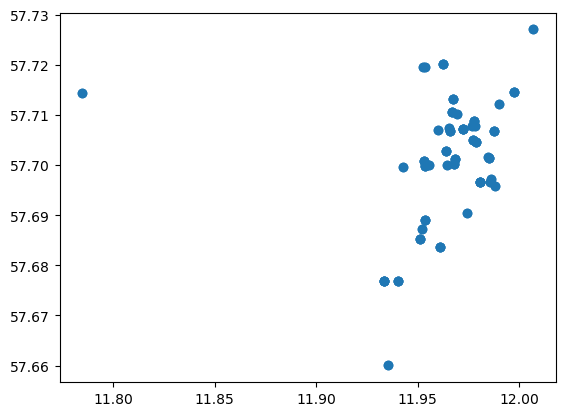

In [3]:
plt.scatter(cams.Longitude, cams.Latitude)

### Camera IDs

We verified that all the data are from the same group of cameras.

## Data

In [4]:
raw = pd.read_pickle("traffic_data/dataset2/dens_0201")
raw.columns = raw.columns.map(lambda x: "Cam" + x[x.find("Cam") + 3:])
day_number = 0 # The first file from the files dens_*

We are missing some hours during the night, so we will set those to 0.

Per day we will have $24 \text{ hours} \times 60 \text{ minutes} = 1440 \text{ minutes}$.

In [5]:
cameras_used = raw.columns

### Merge all data

In [6]:
folder_path = "traffic_data/dataset2/"
prefix="dens_"

dates_list = []
for filename in os.listdir(folder_path):
        # Check if the filename starts with the specified prefix
        if filename.startswith(prefix):
            dates_list.append(filename[5:])

In [7]:
dates_list

['0201',
 '0202',
 '0203',
 '0204',
 '0205',
 '0206',
 '0207',
 '0209',
 '0208',
 '0210',
 '0211',
 '0212',
 '0213',
 '0214',
 '0215',
 '0216',
 '0217',
 '0218',
 '0219',
 '0221',
 '0220',
 '0222',
 '0223',
 '0224',
 '0225',
 '0226',
 '0227',
 '0228',
 '0301',
 '0302',
 '0303',
 '0304',
 '0305',
 '0306',
 '0307',
 '0308',
 '0309',
 '0310',
 '0311',
 '0312',
 '0313',
 '0314',
 '0315',
 '0316',
 '0317',
 '0318',
 '0319',
 '0323',
 '0320',
 '0324',
 '0325',
 '0326',
 '0321',
 '0327',
 '0328',
 '0329',
 '0322',
 '0330',
 '0331',
 '0401',
 '0402',
 '0403',
 '0404',
 '0405',
 '0406',
 '0407',
 '0408',
 '0409',
 '0410',
 '0411',
 '0412',
 '0413',
 '0414',
 '0415',
 '0416',
 '0417',
 '0418',
 '0419',
 '0420',
 '0421',
 '0422',
 '0423',
 '0424',
 '0425',
 '0426',
 '0427',
 '0428',
 '0429',
 '0430',
 '0501',
 '0502',
 '0503',
 '0504',
 '0505',
 '0506',
 '0507',
 '0508',
 '0509',
 '0510',
 '0511',
 '0512',
 '0513',
 '0514',
 '0515',
 '0516',
 '0517',
 '0518',
 '0519',
 '0520',
 '0521',
 '0522',
 

In [8]:
len(dates_list)

181

In [9]:
number_of_days = len(dates_list)
data = pd.DataFrame([])
data["Timestamp"] = range(1440 * number_of_days)
data[raw.columns] = 0
data

,Timestamp,Cam2,Cam4,Cam5,Cam7,Cam10,Cam14,Cam15,Cam16,Cam17,...,Cam99,Cam103,Cam104,Cam105,Cam111,Cam112,Cam113,Cam114,Cam115,Cam116
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260635,260635,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260636,260636,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260637,260637,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260638,260638,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
def concatenate_files():
    progress_bar = tqdm(total=len(dates_list), desc="Concatenating files", unit="files")

    for day_number, date in enumerate(dates_list):
        raw = pd.read_pickle("traffic_data/dataset2/dens_" + date)
        raw.columns = raw.columns.map(lambda x: "Cam" + x[x.find("Cam") + 3:])  
        
        for camera in raw.columns:
            camera_data = raw[camera].dropna()
            camera_data.index = camera_data.apply(lambda x: x[1]).index.map(lambda x: x + day_number*1440)
            data.loc[camera_data.apply(lambda x: day_number*1440 + int(x[0][0:2])*60 + int(x[0][2:4])), camera] = camera_data.apply(lambda x: x[1])
            # print(data.loc[camera_data.apply(lambda x: day_number*1440 + int(x[0][0:2])*60 + int(x[0][2:4])), camera])
            
        progress_bar.update(1)

    progress_bar.close()

concatenate_files()

data = data[data>=0]
data.fillna(0, inplace=True)

Concatenating files: 100%|██████████| 181/181 [00:39<00:00,  4.55files/s]


In [11]:
data

,Timestamp,Cam2,Cam4,Cam5,Cam7,Cam10,Cam14,Cam15,Cam16,Cam17,...,Cam99,Cam103,Cam104,Cam105,Cam111,Cam112,Cam113,Cam114,Cam115,Cam116
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260635,260635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260636,260636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260637,260637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260638,260638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
smooth_int = 5
smooth_len = int(data.shape[0]/smooth_int)
smooth_len

52128

In [13]:
data_smooth = pd.DataFrame([], columns=data.columns, dtype=float)
data_smooth["Timestamp"] = range(smooth_len)
data_smooth

,Timestamp,Cam2,Cam4,Cam5,Cam7,Cam10,Cam14,Cam15,Cam16,Cam17,...,Cam99,Cam103,Cam104,Cam105,Cam111,Cam112,Cam113,Cam114,Cam115,Cam116
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52123,52123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52124,52124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52125,52125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52126,52126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
data.drop(["Timestamp"], axis=1, inplace=True)

In [15]:
from numba import jit
from tqdm import tqdm

@jit(nopython=True)  # Decorate your function with @jit
def smooth_data(data, smooth_len, smooth_int):
    num_rows = data.shape[0]
    num_cols = data.shape[1]
    smoothed_data = np.zeros((smooth_len, num_cols))  # Initialize smoothed data array

    for col in range(num_cols):
        for i in range(smooth_len):
            start_idx = i * smooth_int
            end_idx = (i + 1) * smooth_int
            for j in range(start_idx, end_idx):
                smoothed_data[i, col] += data[j, col]
            smoothed_data[i, col] /= smooth_int

    return smoothed_data

# Call the smoothed_data function
smoothed_data = smooth_data(data.values, smooth_len, smooth_int)

# Convert the smoothed data array back to a DataFrame
data_smooth = pd.DataFrame(smoothed_data, columns=data.columns)

In [16]:
data_smooth

,Cam2,Cam4,Cam5,Cam7,Cam10,Cam14,Cam15,Cam16,Cam17,Cam20,...,Cam99,Cam103,Cam104,Cam105,Cam111,Cam112,Cam113,Cam114,Cam115,Cam116
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

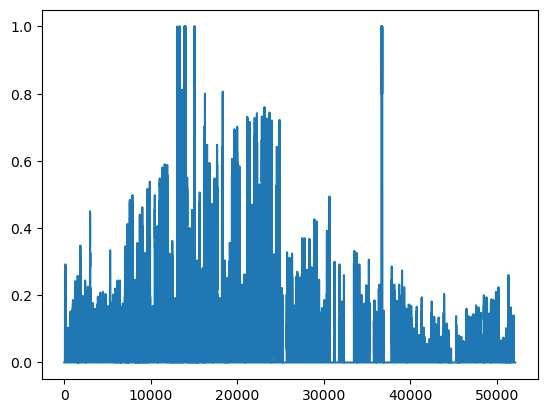

In [17]:
data_smooth.Cam116.plot()

<Axes: >

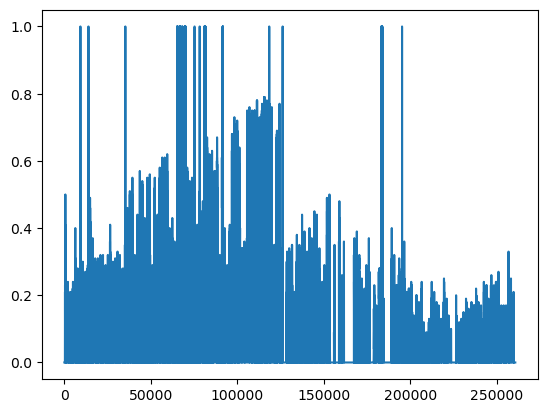

In [18]:
data.Cam116.plot()

<Axes: >

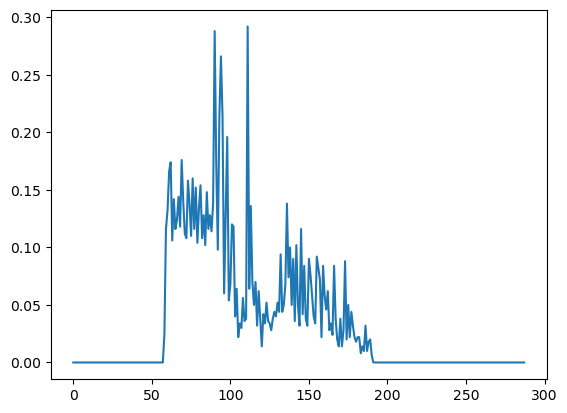

In [19]:
data_smooth.Cam116[:288].plot()

<Axes: >

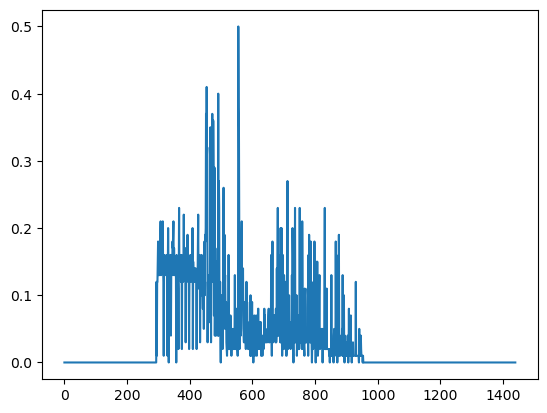

In [20]:
data.Cam116[:288*5].plot()

In [21]:
os.makedirs("stgan-algo/STGAN/ximantis_smooth_2/data", exist_ok=True)

In [22]:
# Save
np.save("stgan-algo/STGAN/ximantis_smooth_2/data/data.npy", data_smooth)

In [23]:
data_tensor = torch.tensor(np.load("stgan-algo/STGAN/ximantis_smooth_2/data/data.npy"), dtype=torch.float)
data_tensor.shape

torch.Size([52128, 42])

In [24]:
data_tensor = data_tensor.reshape([data_tensor.shape[0], data_tensor.shape[1], 1, 1])
data_tensor.shape

torch.Size([52128, 42, 1, 1])

In [25]:
# Save
# np.save("stgan-algo/STGAN/ximantis_smooth_2/data/data.npy", data_tensor.repeat([1,1,1,2]).numpy())
np.save("stgan-algo/STGAN/ximantis_smooth_2/data/data.npy", data_tensor.numpy())

## Node distances

In [26]:
cams

,CamId,Longitude,Latitude,Bearing
0,1,11.986280,57.697137,155
1,2,11.985522,57.696668,85
2,4,11.965964,57.706792,90
3,5,11.977686,57.708775,175
4,6,11.972374,57.707239,60
...,...,...,...,...
129,115,11.968668,57.701172,240
130,116,11.968668,57.701172,60
131,117,11.967943,57.700256,250
132,118,11.967943,57.700256,70


In [27]:
cameras_used

Index(['Cam2', 'Cam4', 'Cam5', 'Cam7', 'Cam10', 'Cam14', 'Cam15', 'Cam16',
       'Cam17', 'Cam20', 'Cam23', 'Cam24', 'Cam25', 'Cam27', 'Cam29', 'Cam30',
       'Cam44', 'Cam45', 'Cam46', 'Cam49', 'Cam51', 'Cam72', 'Cam73', 'Cam79',
       'Cam80', 'Cam81', 'Cam88', 'Cam93', 'Cam94', 'Cam95', 'Cam96', 'Cam98',
       'Cam99', 'Cam103', 'Cam104', 'Cam105', 'Cam111', 'Cam112', 'Cam113',
       'Cam114', 'Cam115', 'Cam116'],
      dtype='object')

In [28]:
cameras_used = cameras_used.map(lambda x: int(x[3:]))
cameras_used

Int64Index([  2,   4,   5,   7,  10,  14,  15,  16,  17,  20,  23,  24,  25,
             27,  29,  30,  44,  45,  46,  49,  51,  72,  73,  79,  80,  81,
             88,  93,  94,  95,  96,  98,  99, 103, 104, 105, 111, 112, 113,
            114, 115, 116],
           dtype='int64')

In [29]:
cameras_used = list(cameras_used)

In [30]:
dists = pd.DataFrame(columns=cameras_used, index=cameras_used)
dists

,2,4,5,7,10,14,15,16,17,20,...,99,103,104,105,111,112,113,114,115,116
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
radius = 6_400
for i in cameras_used:
    for j in cameras_used:
        dx = (cams.Longitude[i] - cams.Longitude[j]) * 2 * np.pi / 360 * radius
        dy = (cams.Latitude[i] - cams.Latitude[j]) * 2 * np.pi / 360 * radius
        dists.loc[i,j] = np.sqrt(dx**2 + dy**2)

In [32]:
dists

,2,4,5,7,10,14,15,16,17,20,...,99,103,104,105,111,112,113,114,115,116
2,0.0,0.717743,0.717743,0.436629,0.066994,1.327964,2.05584,1.398109,2.242567,0.73866,...,1.561136,0.495896,0.495896,20.256281,6.246701,4.414757,4.414757,1.554838,1.554838,2.914142
4,0.717743,0.0,0.0,0.688644,0.746783,0.617664,1.885991,0.680382,1.584234,0.867626,...,2.229982,1.059513,1.059513,20.969753,6.705549,4.946503,4.946503,1.834452,1.834452,3.403247
5,0.717743,0.0,0.0,0.688644,0.746783,0.617664,1.885991,0.680382,1.584234,0.867626,...,2.229982,1.059513,1.059513,20.969753,6.705549,4.946503,4.946503,1.834452,1.834452,3.403247
7,0.436629,0.688644,0.688644,0.0,0.392115,1.192621,2.383023,1.29961,2.268323,0.305747,...,1.905217,0.929764,0.929764,20.375988,6.668337,4.819473,4.819473,1.211443,1.211443,3.335464
10,0.066994,0.746783,0.746783,0.392115,0.0,1.34983,2.122833,1.425657,2.288618,0.68884,...,1.565287,0.538166,0.538166,20.223207,6.279906,4.440216,4.440216,1.489405,1.489405,2.946911
14,1.327964,0.617664,0.617664,1.192621,1.34983,0.0,2.073093,0.145148,1.183065,1.248351,...,2.845429,1.669133,1.669133,21.557102,7.216022,5.503181,5.503181,2.14038,2.14038,3.948823
15,2.05584,1.885991,1.885991,2.383023,2.122833,2.073093,0.0,1.974372,1.716682,2.66077,...,2.538507,1.810886,1.810886,21.359441,5.546546,4.128391,4.128391,3.589654,3.589654,2.651389
16,1.398109,0.680382,0.680382,1.29961,1.425657,0.145148,1.974372,0.0,1.040549,1.375191,...,2.887291,1.705979,1.705979,21.64564,7.18429,5.4935,5.4935,2.279225,2.279225,3.936014
17,2.242567,1.584234,1.584234,2.268323,2.288618,1.183065,1.716682,1.040549,0.0,2.392905,...,3.522212,2.387473,2.387473,22.445921,7.251985,5.741857,5.741857,3.317323,3.317323,4.202995
20,0.73866,0.867626,0.867626,0.305747,0.68884,1.248351,2.66077,1.375191,2.392905,0.0,...,2.131034,1.226167,1.226167,20.404112,6.943947,5.07945,5.07945,0.967552,0.967552,3.613073


In [33]:
dists.to_csv("stgan-algo/STGAN/ximantis_smooth_2/data/node_dist.txt", sep=" ", header=False, index=False)

## Adjacent nodes

In [34]:
dists

,2,4,5,7,10,14,15,16,17,20,...,99,103,104,105,111,112,113,114,115,116
2,0.0,0.717743,0.717743,0.436629,0.066994,1.327964,2.05584,1.398109,2.242567,0.73866,...,1.561136,0.495896,0.495896,20.256281,6.246701,4.414757,4.414757,1.554838,1.554838,2.914142
4,0.717743,0.0,0.0,0.688644,0.746783,0.617664,1.885991,0.680382,1.584234,0.867626,...,2.229982,1.059513,1.059513,20.969753,6.705549,4.946503,4.946503,1.834452,1.834452,3.403247
5,0.717743,0.0,0.0,0.688644,0.746783,0.617664,1.885991,0.680382,1.584234,0.867626,...,2.229982,1.059513,1.059513,20.969753,6.705549,4.946503,4.946503,1.834452,1.834452,3.403247
7,0.436629,0.688644,0.688644,0.0,0.392115,1.192621,2.383023,1.29961,2.268323,0.305747,...,1.905217,0.929764,0.929764,20.375988,6.668337,4.819473,4.819473,1.211443,1.211443,3.335464
10,0.066994,0.746783,0.746783,0.392115,0.0,1.34983,2.122833,1.425657,2.288618,0.68884,...,1.565287,0.538166,0.538166,20.223207,6.279906,4.440216,4.440216,1.489405,1.489405,2.946911
14,1.327964,0.617664,0.617664,1.192621,1.34983,0.0,2.073093,0.145148,1.183065,1.248351,...,2.845429,1.669133,1.669133,21.557102,7.216022,5.503181,5.503181,2.14038,2.14038,3.948823
15,2.05584,1.885991,1.885991,2.383023,2.122833,2.073093,0.0,1.974372,1.716682,2.66077,...,2.538507,1.810886,1.810886,21.359441,5.546546,4.128391,4.128391,3.589654,3.589654,2.651389
16,1.398109,0.680382,0.680382,1.29961,1.425657,0.145148,1.974372,0.0,1.040549,1.375191,...,2.887291,1.705979,1.705979,21.64564,7.18429,5.4935,5.4935,2.279225,2.279225,3.936014
17,2.242567,1.584234,1.584234,2.268323,2.288618,1.183065,1.716682,1.040549,0.0,2.392905,...,3.522212,2.387473,2.387473,22.445921,7.251985,5.741857,5.741857,3.317323,3.317323,4.202995
20,0.73866,0.867626,0.867626,0.305747,0.68884,1.248351,2.66077,1.375191,2.392905,0.0,...,2.131034,1.226167,1.226167,20.404112,6.943947,5.07945,5.07945,0.967552,0.967552,3.613073


### Reset indices of nodes

In [35]:
dists = pd.read_csv("stgan-algo/STGAN/ximantis_smooth_2/data/node_dist.txt", delimiter=" ", names=range(len(cameras_used)))
dists

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.000000,0.717743,0.717743,0.436629,0.066994,1.327964,2.055840,1.398109,2.242567,0.738660,...,1.561136,0.495896,0.495896,20.256281,6.246701,4.414757,4.414757,1.554838,1.554838,2.914142
1,0.717743,0.000000,0.000000,0.688644,0.746783,0.617664,1.885991,0.680382,1.584234,0.867626,...,2.229982,1.059513,1.059513,20.969753,6.705549,4.946503,4.946503,1.834452,1.834452,3.403247
2,0.717743,0.000000,0.000000,0.688644,0.746783,0.617664,1.885991,0.680382,1.584234,0.867626,...,2.229982,1.059513,1.059513,20.969753,6.705549,4.946503,4.946503,1.834452,1.834452,3.403247
3,0.436629,0.688644,0.688644,0.000000,0.392115,1.192621,2.383023,1.299610,2.268323,0.305747,...,1.905217,0.929764,0.929764,20.375988,6.668337,4.819473,4.819473,1.211443,1.211443,3.335464
4,0.066994,0.746783,0.746783,0.392115,0.000000,1.349830,2.122833,1.425657,2.288618,0.688840,...,1.565287,0.538166,0.538166,20.223207,6.279906,4.440216,4.440216,1.489405,1.489405,2.946911
5,1.327964,0.617664,0.617664,1.192621,1.349830,0.000000,2.073093,0.145148,1.183065,1.248351,...,2.845429,1.669133,1.669133,21.557102,7.216022,5.503181,5.503181,2.140380,2.140380,3.948823
6,2.055840,1.885991,1.885991,2.383023,2.122833,2.073093,0.000000,1.974372,1.716682,2.660770,...,2.538507,1.810886,1.810886,21.359441,5.546546,4.128391,4.128391,3.589654,3.589654,2.651389
7,1.398109,0.680382,0.680382,1.299610,1.425657,0.145148,1.974372,0.000000,1.040549,1.375191,...,2.887291,1.705979,1.705979,21.645640,7.184290,5.493500,5.493500,2.279225,2.279225,3.936014
8,2.242567,1.584234,1.584234,2.268323,2.288618,1.183065,1.716682,1.040549,0.000000,2.392905,...,3.522212,2.387473,2.387473,22.445921,7.251985,5.741857,5.741857,3.317323,3.317323,4.202995
9,0.738660,0.867626,0.867626,0.305747,0.688840,1.248351,2.660770,1.375191,2.392905,0.000000,...,2.131034,1.226167,1.226167,20.404112,6.943947,5.079450,5.079450,0.967552,0.967552,3.613073


### For one node

In [36]:
# The first 9 nearest neighbours
knn = 9
dists.loc[2].sort_values()[:knn].index

Int64Index([1, 2, 21, 11, 5, 25, 7, 3, 22], dtype='int64')

In [37]:
dists.loc[2].sort_values()[:knn].index

Int64Index([1, 2, 21, 11, 5, 25, 7, 3, 22], dtype='int64')

In [38]:
adj = pd.DataFrame([], columns=range(knn))
adj.loc[2] = list(dists.loc[2].sort_values()[:knn].index)
adj

,0,1,2,3,4,5,6,7,8
2,1,2,21,11,5,25,7,3,22


In [39]:
adj = pd.DataFrame([], columns=range(knn))
for i in range(len(cameras_used)):
    adj.loc[i] = list(dists.loc[i].sort_values()[:knn].index)
adj

,0,1,2,3,4,5,6,7,8
0,0,4,22,3,33,34,11,2,1
1,1,2,21,11,5,25,7,3,22
2,1,2,21,11,5,25,7,3,22
3,3,22,11,9,4,0,1,2,21
4,4,0,3,22,11,33,34,9,1
5,5,25,7,1,2,21,11,24,23
6,6,10,15,31,8,33,34,21,2
7,7,5,25,1,2,21,24,23,8
8,8,24,23,10,7,5,25,1,2
9,9,3,22,11,4,0,1,2,21


In [40]:
adj.to_csv("stgan-algo/STGAN/ximantis_smooth_2/data/node_adjacent.txt", sep=" ", header=False, index=False)

## Node subgraph

In [41]:
stdev = np.array(dists).std()
stdev

3.9830436117637107

In [42]:
# Consider cameras adjacent only when they are closer that 0.5 km
dists = dists[dists<0.5]
dists = dists.fillna(1000000)

In [43]:
W = np.exp(-dists**2/stdev**2)
for i in range(len(W)):
    W.loc[i,i] = 0   
W

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.000000,0.000000,0.000000,0.988055,0.999717,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.984619,0.984619,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.988055,0.000000,0.000000,0.000000,0.990355,0.000000,0.0,0.000000,0.0,0.994125,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.999717,0.000000,0.000000,0.990355,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.998673,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.998673,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9,0.000000,0.000000,0.000000,0.994125,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [44]:
W.loc[adj.loc[0], adj.loc[0]]

,0,4,22,3,33,34,11,2,1
0,0.000000,0.999717,0.988055,0.988055,0.984619,0.984619,0.000000,0.000000,0.000000
4,0.999717,0.000000,0.990355,0.990355,0.000000,0.000000,0.000000,0.000000,0.000000
22,0.988055,0.990355,0.000000,1.000000,0.000000,0.000000,0.996123,0.000000,0.000000
3,0.988055,0.990355,1.000000,0.000000,0.000000,0.000000,0.996123,0.000000,0.000000
33,0.984619,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
34,0.984619,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
11,0.000000,0.000000,0.996123,0.996123,0.000000,0.000000,0.000000,0.986397,0.986397
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.986397,0.000000,1.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.986397,1.000000,0.000000


In [45]:
np.exp(-(dists.loc[adj.loc[0], adj.loc[0]]**2 / stdev**2))

,0,4,22,3,33,34,11,2,1
0,1.000000,0.999717,0.988055,0.988055,0.984619,0.984619,0.000000,0.000000,0.000000
4,0.999717,1.000000,0.990355,0.990355,0.000000,0.000000,0.000000,0.000000,0.000000
22,0.988055,0.990355,1.000000,1.000000,0.000000,0.000000,0.996123,0.000000,0.000000
3,0.988055,0.990355,1.000000,1.000000,0.000000,0.000000,0.996123,0.000000,0.000000
33,0.984619,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
34,0.984619,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
11,0.000000,0.000000,0.996123,0.996123,0.000000,0.000000,1.000000,0.986397,0.986397
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.986397,1.000000,1.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.986397,1.000000,1.000000


In [46]:
test = W.loc[adj.loc[0], adj.loc[0]]

In [47]:
torch.from_numpy(test.to_numpy())

tensor([[0.0000, 0.9997, 0.9881, 0.9881, 0.9846, 0.9846, 0.0000, 0.0000, 0.0000],
        [0.9997, 0.0000, 0.9904, 0.9904, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9881, 0.9904, 0.0000, 1.0000, 0.0000, 0.0000, 0.9961, 0.0000, 0.0000],
        [0.9881, 0.9904, 1.0000, 0.0000, 0.0000, 0.0000, 0.9961, 0.0000, 0.0000],
        [0.9846, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.9846, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9961, 0.9961, 0.0000, 0.0000, 0.0000, 0.9864, 0.9864],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9864, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9864, 1.0000, 0.0000]],
       dtype=torch.float64)

In [48]:
node_subgraph = torch.empty((len(cameras_used), knn, knn))
node_subgraph.shape

torch.Size([42, 9, 9])

In [49]:
for i in range(len(cameras_used)):
    node_subgraph[i,:,:] = torch.from_numpy(W.loc[adj.loc[i], adj.loc[i]].to_numpy())

In [50]:
node_subgraph.shape

torch.Size([42, 9, 9])

In [51]:
node_subgraph[0,:,:]

tensor([[0.0000, 0.9997, 0.9881, 0.9881, 0.9846, 0.9846, 0.0000, 0.0000, 0.0000],
        [0.9997, 0.0000, 0.9904, 0.9904, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9881, 0.9904, 0.0000, 1.0000, 0.0000, 0.0000, 0.9961, 0.0000, 0.0000],
        [0.9881, 0.9904, 1.0000, 0.0000, 0.0000, 0.0000, 0.9961, 0.0000, 0.0000],
        [0.9846, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.9846, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9961, 0.9961, 0.0000, 0.0000, 0.0000, 0.9864, 0.9864],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9864, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9864, 1.0000, 0.0000]])

In [52]:
np.save("stgan-algo/STGAN/ximantis_smooth_2/data/node_subgraph.npy", node_subgraph.numpy())

## Time feature

In [53]:
time_features = np.zeros([data_smooth.shape[0], 24 + 7])

In [54]:
time_features = pd.DataFrame(time_features, dtype=int)

In [55]:
time_features

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Hour one-hot encoding
timestamp = 12
day_length = 24 * 12
for i in range(len(time_features)):
    hour = divmod(divmod(i, day_length)[1], timestamp)[0]
    time_features.loc[i, hour] = 1

In [57]:
# Day one-hot encoding
timestamp = 12
day_length = 24 * 12
week_length = 7
starting_day = 4 # The starting day, feb 1, 2019, is Friday
for i in range(len(time_features)):
    weekday = divmod(divmod(i, day_length)[0], week_length)[1]
    time_features.loc[i, 24 + divmod(starting_day + weekday, week_length)[1]] = 1
    # time_features.loc[i, 24 + weekday] = 1

In [58]:
time_features

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52123,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
52124,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
52125,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
52126,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [59]:
time_features.to_csv("stgan-algo/STGAN/ximantis_smooth_2/data/time_features.txt", sep=" ", header=False, index=False)